Import stuff

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
import astropy.coordinates as coord
import sep
import healpy as hp

# Import output from random stacking

This is the fits image produced by running COOP to stack, with random orientation, the cluster map on the cluster points.

In [9]:
hdu = fits.open("/home/mlokken/stacking/DES/stacks/rm_random_stack_z.65toz.68_2am.fits")
img = hdu[0].data
imgsw = img.byteswap(False).newbyteorder()

FORMAT  =HEALPIX                                                                 [astropy.io.fits.card]
MAP     =/mnt/scratch-lustre/mlokken/y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6 [astropy.io.fits.card]
FWHM_IN =2.                                                                      [astropy.io.fits.card]
PEAKS   =/home/mlokken/stacking/DES/peaks/rm_random_z.65toz.68_2am.fits          [astropy.io.fits.card]
MASK    =/mnt/scratch-lustre/mlokken/y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6 [astropy.io.fits.card]
FIELD   =I                                                                       [astropy.io.fits.card]
RADIUS  =1                                                                       [astropy.io.fits.card]
RES     =200 #                                                                   [astropy.io.fits.card]
OUTPUT  =/home/mlokken/stacking/DES/stacks/rm_random_stack_z.65toz.68_2am        [astropy.io.fits.card]
COLORTAB=jet                                                    

In [10]:
width = len(img[0])
length = len(img[1])
midpixw = width/2 + .5
midpixl = length/2 + .5

In [11]:
radius = coord.Angle(int(hdu[0].header['RADIUS'][1:2])*u.degree)
res = int(hdu[0].header['RES'][1:4])
pixsize = radius/res
pixsize = pixsize.to(u.arcmin)
print(pixsize, "pixels")

0.3arcmin pixels


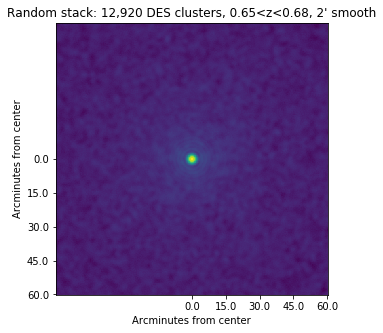

In [39]:
plt.figure(figsize=[5,5])
plt.imshow(np.log(imgsw))
locsx,labelsx=plt.xticks()
labels_amx = locsx * pixsize.value - 60.0
labelstx = [str(lab)for lab in labels_amx]
plt.xticks(locsx[5:10], labelstx[5:10])
locsy,labelsy=plt.yticks()
labels_amy = locsy * pixsize.value - 60.0
labelsty = [str(lab)for lab in labels_amy]
plt.yticks(locsy[5:10], labelsty[5:10])
plt.xlabel("Arcminutes from center")
plt.ylabel("Arcminutes from center")
plt.title("Random stack: 12,920 DES clusters, 0.65<z<0.68, 2' smooth")
plt.savefig("/home/mlokken/stacking/DES/stacks/rm_random_stack_z.65toz.68_2am_labels.pdf")

Select a length to bin pixels as you move out from the center of the image to the outside.

In [29]:
r_bin = coord.Angle(1 *u.arcmin)
pix_bin = r_bin//pixsize
no_sums = int(width/2//pix_bin)
no_sums, pix_bin
pix_bin * pixsize

<Angle 0.9 arcmin>

In [30]:
sums = []
bin_cents = []
for i in range(0, no_sums): #moving out from the center in bin sizes of r_bin
    r_in = pix_bin * (i+3) #start the inner radius at 4 r_bin length away from the center to avoid including the center flux
    r_out = r_in + pix_bin #outer radius of annulus
    bin_cent = (r_in+r_out)/2.
    tot = sep.sum_circann(imgsw, midpixw, midpixl, r_in, r_out)[0]
    ann_area = np.pi*r_out**2 - np.pi*r_in**2
    i_per_a = tot/ann_area #intensity per unit area on image
    sums.append(i_per_a)
    bin_cents.append(bin_cent)

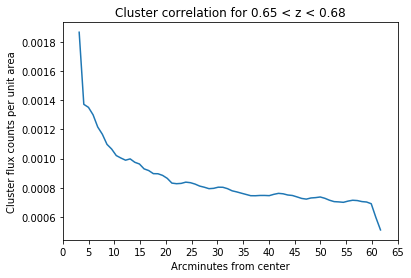

In [40]:
plt.plot(bin_cents* pixsize, sums)
ticks = np.arange(0,70, 5)
plt.xticks(ticks)
plt.xlabel('Arcminutes from center')
plt.title("Cluster correlation for 0.65 < z < 0.68")
plt.ylabel('Cluster flux counts per unit area')
plt.savefig('/home/mlokken/stacking/DES/clust_corr_z.65toz.68_2am.pdf')

In [9]:
idx, = np.where(sums == np.amax(sums))[0]
print(idx)
pk_loc = bin_cents[idx] * pixsize
print("The typical cluster separation is %s" %pk_loc)

0
The typical cluster separation is 1.35arcmin


Comoving distance corresponding to ~13'?

In [41]:
from astropy.cosmology import Planck15 as cosmo

In [46]:
corr_len = coord.Angle(13 *u.arcmin)
corr_len_r = corr_len.to(u.rad)
ang_d_dist = cosmo.angular_diameter_distance(0.67) * corr_len_r.value
ang_d_dist

<Quantity 5.63502289 Mpc>